This dataset (as far as I understand) provides information retrieved through an informative system called HappyForce https://www.myhappyforce.com/en/  aimed at collecting data about employees satisfaction and happyness. 

By means of an app  employees have been asked to answer a question?
**"How happy ar you today at work?**
The following answers were possible:
- 4 Great
- 3 Good
- 2 So So
- 1 Pretty Bad

Whenever they want they can post this feeback about their happiness and leave a comment. The can also like or dislike comments. Plesae visit the related site for complete and correct information.
![happyforce](https://www.myhappyforce.com/wp-content/themes/happyforce/img/app.png)

Some important references are 
* [1] J. Berengueres, G. Duran, D. Castro, Happiness,an inside job? Turnoverprediction using employee likeability, engagement and relative happiness, ASONAM 2017, Sidney.
* [2] https://www.slideshare.net/harriken/ieee-happiness-an-inside-job-asoman-2017
* [3] https://www.myhappyforce.com/en/ 

According to [1] the data spans 2.5 years and 4,356 employees of 34 companies  based  in  Barcelona.

This dataset is amazingly interesting because it provides different perspectives on an elusive phaenomenon like employees happines. It also provides different data challenges like:
- time series like the trend of happiness self perception in time or the thrend of posted comments, etc.;
- networks analysis of social interactions (i.e. likes, dislikes, etc.);
- clustering;
- prediction (i.e. predict whether an employee will evntually leave the company at the end of the observation time)

## Loading and Wrangling Data

First of all I am going to prepare the data for the analysis I want to perform. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

churn.csv
commentInteractions.csv
comments_clean_anonimized.csv
votes.csv



In [2]:
churn = pd.read_csv('../input/churn.csv')
churn.head()

,employee,companyAlias,numVotes,lastParticipationDate,stillExists
0,512,56aec740f1ef260003e307d6,4,Thu Feb 23 12:48:04 CET 2017,True
1,-2,56aec740f1ef260003e307d6,0,Wed Jan 18 14:00:55 CET 2017,False
2,2,56aec740f1ef260003e307d6,72,Fri Mar 17 01:00:00 CET 2017,True
3,487,56aec740f1ef260003e307d6,14,Sat Nov 19 15:02:14 CET 2016,False
4,3,56aec740f1ef260003e307d6,22,Thu Feb 16 01:00:00 CET 2017,True


In [3]:
ci = pd.read_csv('../input/commentInteractions.csv')
ci.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,employee,companyAlias,liked,disliked,commentId
0,307,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
1,36,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
2,276,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
3,24,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
4,382,56aec740f1ef260003e307d6,True,False,58d0179ae010990004e3806d


In [4]:
ci.shape

(336960, 5)

In [5]:
cc = pd.read_csv('../input/comments_clean_anonimized.csv')
cc.head()

,employee,companyAlias,commentId,txt,likes,dislikes,commentDate
0,307,56aec740f1ef260003e307d6,58d018d7e010990004e38070,**********************************************...,4.0,0.0,Mon Mar 20 19:00:17 CET 2017
1,382,56aec740f1ef260003e307d6,58d0179ae010990004e3806d,*****************************,1.0,2.0,Mon Mar 20 18:55:16 CET 2017
2,172,56aec740f1ef260003e307d6,58cff8cde010990004e37f6a,***************************,3.0,0.0,Mon Mar 20 16:44:02 CET 2017
3,135,56aec740f1ef260003e307d6,58cfefeee010990004e37f60,***************************,1.0,1.0,Mon Mar 20 16:06:08 CET 2017
4,225,56aec740f1ef260003e307d6,58cfd9b4e010990004e37f52,*********************************,3.0,2.0,Mon Mar 20 14:30:50 CET 2017


In [6]:
votes = pd.read_csv('../input/votes.csv')
votes.head()

,employee,companyAlias,voteDate,vote
0,31,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,4
1,33,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,4
2,79,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,4
3,94,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,4
4,16,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,2


In [7]:
len(votes['companyAlias'].unique())

37

There are 37 companies ([1] claims data are gathered from 34 compnies). I am going to get the list of unique company ids and use it to chang their occurrences (i.e. in the votes dataframe) with the company ids index (a shorter and thus easier to manage integer).

In [8]:
companies = pd.Series(votes['companyAlias'].unique())
vc = [companies.values.tolist().index(company) for company in votes['companyAlias'].values]
churn_company = [companies.values.tolist().index(company) if company in companies.values else -1 for company in churn['companyAlias'].values ]
comment_company = [companies.values.tolist().index(company) if company in companies.values else -1 for company in ci['companyAlias'].values ]
comment_company2 = [companies.values.tolist().index(company) if company in companies.values else -1 for company in cc['companyAlias'].values ]

votes['companyAlias'] = vc
churn['companyAlias'] = churn_company
ci['companyAlias'] = comment_company
cc['companyAlias'] = comment_company2

In [9]:
dates = votes['voteDate'].str.replace('CET','')
dates = dates.str.replace('CEST','')
votes['voteDate']= dates

In [10]:
votes['voteDate'] = pd.to_datetime(votes['voteDate'],format="%a %b %d %H:%M:%S %Y")

In [11]:
votes['wday'] = votes['voteDate'].dt.dayofweek
votes['yday'] = votes['voteDate'].dt.dayofyear
votes['year'] = votes['voteDate'].dt.year

In [12]:
votes['year'].unique()

array([2016, 2017, 2015, 2014])

We are dealing with four years of observations ranging from 2014 to 2017.

In [13]:
votes['year'] = votes['year']-2014

In [14]:
votes['employee'] = votes['companyAlias'].astype(str)+"_"+votes['employee'].astype(str)
churn['employee'] = churn['companyAlias'].astype(str)+"_"+churn['employee'].astype(str)
ci['employee'] = ci['companyAlias'].astype(str)+"_"+ci['employee'].astype(str)
cc['employee'] = cc['companyAlias'].astype(str)+"_"+cc['employee'].astype(str)

len(votes['employee'].unique())

4377

We are dealing with 4377 employees. Let's aggredate data on employee basis

In [15]:
employee = votes.groupby('employee',as_index=False).mean()
employee = employee.merge(churn,on=['employee','employee'],how='left').drop_duplicates(subset="employee")

In [16]:
employee['companyAlias'] = employee.companyAlias_x.astype(int)
employee = employee.drop(['companyAlias_x','companyAlias_y'],axis=1)
employee.head()

,employee,vote,wday,yday,year,numVotes,lastParticipationDate,stillExists,companyAlias
0,0_10,3.482143,1.910714,188.821429,2.232143,56,Fri Mar 10 01:00:00 CET 2017,True,0
1,0_100,4.000000,2.898396,190.347594,2.379679,187,Mon Mar 20 08:11:08 CET 2017,True,0
2,0_101,2.663462,2.929487,193.314103,2.253205,312,Mon Mar 20 08:11:08 CET 2017,True,0
3,0_102,3.755102,2.869388,200.910204,2.293878,245,Mon Mar 20 01:00:00 CET 2017,True,0
4,0_103,3.945274,2.840796,183.512438,2.278607,201,Mon Mar 20 01:00:00 CET 2017,True,0


## Self-reported Happyness

By means of an app [3] employees have been asked to answer a question?
**"How happy ar you today at work?**
The following answers were possible:
- 4 Great
- 3 Good
- 2 So So
- 1 Pretty Bad

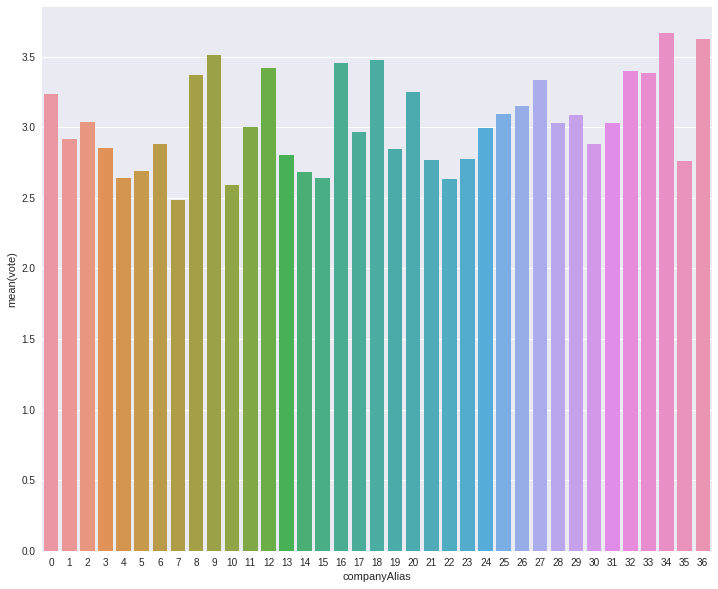

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

f,axarr = fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
data =votes.groupby('companyAlias').mean()
sns.barplot(x=data.index,y= data['vote'])

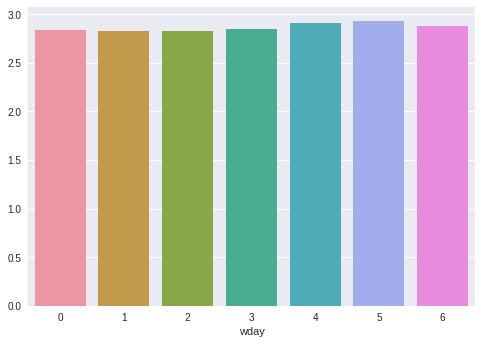

In [18]:
week_happ = votes.groupby('wday').mean()['vote']
sns.barplot(x = week_happ.index, y = week_happ.values)

In [19]:
churn_employee = employee[employee['stillExists']==True]
churn_employee = churn_employee.groupby('companyAlias').count()
tmp = employee.groupby('companyAlias',as_index=False).count()
churn_perc = 1- churn_employee['stillExists'].astype(float)/tmp['stillExists']
churn_perc = [0 if np.isnan(perc) else perc for perc in churn_perc]

In [20]:
data['churn_perc'] = churn_perc

We can evaluate possible correlations betweean any pair of feature:

In [21]:
data.corr()

,vote,wday,yday,year,churn_perc
vote,1.000000,-0.186581,0.140144,-0.159414,-0.187026
wday,-0.186581,1.000000,0.239734,-0.187337,0.125843
yday,0.140144,0.239734,1.000000,-0.611599,0.132377
year,-0.159414,-0.187337,-0.611599,1.000000,-0.109831
churn_perc,-0.187026,0.125843,0.132377,-0.109831,1.000000


as we can see  data shows a  negative correlation between the percentage of churn employees and the mean of happiness in the related company. This apparently shows that companies where employees feel unhappy tend to have an higher percentage of churn. The following diagram depicts this trend.

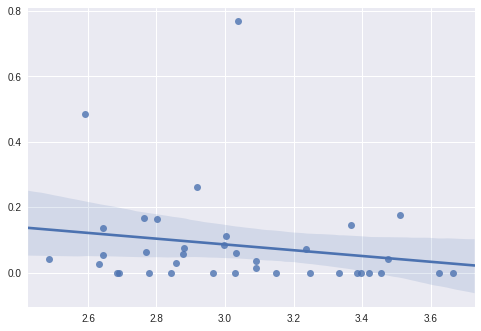

In [22]:
sns.regplot(data['vote'].values,data['churn_perc'].values)

## Being Social Matters

In [23]:
likes = ci[ci['liked']==True].groupby('employee',as_index=False).count()
likes = likes[['employee','liked']]
hates = ci[ci['disliked']==True].groupby('employee',as_index=False).count()
hates = hates[['employee','disliked']]
hated = cc[cc['dislikes']==True].groupby('employee',as_index=False).count()
hated = hated[['employee','dislikes']]
loved = cc[cc['likes']==True].groupby('employee',as_index=False).count()
loved = loved[['employee','likes']]
employee = employee.merge(likes,on='employee',how='left').drop_duplicates(subset="employee")
employee = employee.merge(hates,on='employee',how='left').drop_duplicates(subset="employee")
employee = employee.merge(hated,on='employee',how='left').drop_duplicates(subset="employee")
employee = employee.merge(loved,on='employee',how='left').drop_duplicates(subset="employee")
employee.shape

(4377, 13)

I have counted the number of likes and dislikes for each employee. The following heatmap shows some possible correlations among the employee data. The employee happiness (Vote) seems to be directly related with the possibility that the employee remained in the company. The number of likes and dislikes the employee has given exhibits small correlation.
An interesting thing to note is that the number of likes the employee got to his/her commnents are directly related to his/her perceived happiness and thus (possibly) to the possibility he/she will remain in the company.

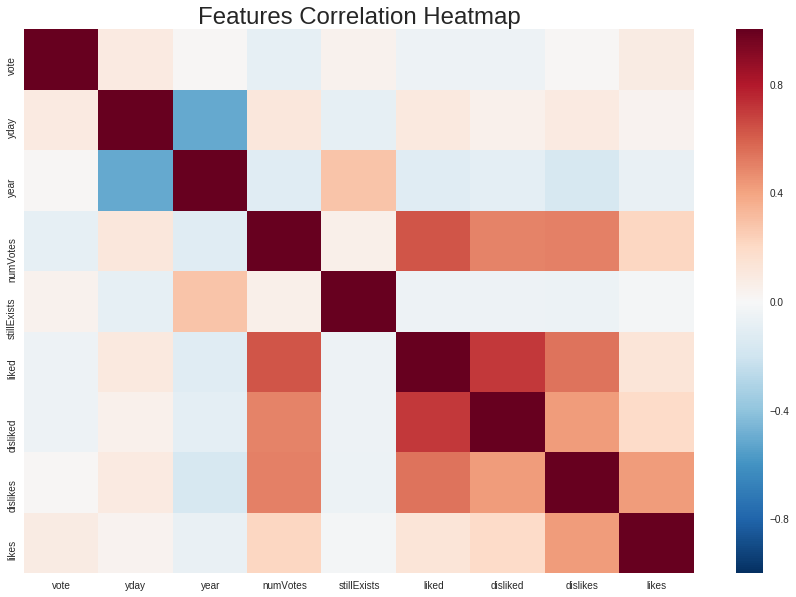

In [24]:
f,ax = plt.subplots(1,1,figsize=(15,10))
red_emp = employee.drop(['companyAlias','lastParticipationDate','wday'],axis=1)
sns.heatmap(red_emp.corr())
plt.title('Features Correlation Heatmap',fontsize=24)
plt.show()

In [25]:
author_comments = cc[['employee','commentId']].drop_duplicates(subset='commentId')
author_dict = {commentId:author_comments['employee'].values[i] for i,commentId in enumerate(author_comments['commentId'].values)}
comments = [commentId for i,commentId in enumerate(author_comments['commentId'].values)]

In [26]:
#this is too computational intensive I will work on subsets
#authors = [author_dict[commentId] if commentId in comments else -1 for commentId in ci['commentId'].values]

In [27]:
from nxviz import CircosPlot

## PCA and Clustering

In this section I am going to find a possible strategy to clusterize the employees. My idea is to create a dataframe of features where each row represents an employee and each column represent a day in the four years of observations. The value in that cell represents the vote (about its happiness) the employee posted, 0 otherwise.

This means 796 features  which are  lot. I therefore use PCA to reduce the number of features to 6. From these 6 components I have chosen 2 which, in my opinion, when plotted in 2D exhibits a distribution which is good for clustering.

In [28]:
votes_feature = votes[['employee','vote','wday','yday']]
votes_feature['yday'] = votes['yday']+ votes['year']*365
dummies = pd.get_dummies(votes_feature['yday'])
for i,row in enumerate(votes_feature.values):
    dummies.loc[i,row[3]]= row[1]
votes_feature=pd.concat([votes_feature,dummies],axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
dummies = votes_feature.groupby('employee',as_index=False).sum().drop(['vote','wday','yday','employee'],axis=1)
dummies.head(2)

,158,329,330,331,332,333,334,335,338,342,...,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


In [30]:
from sklearn.decomposition import PCA

#votes_feature = votes[['vote','wday','yday']]
pca = PCA(n_components=6)
pca.fit(dummies)
components = pca.transform(dummies)
components = pd.DataFrame(components,columns=['c1','c2','c3','c4','c5','c6'])

In [31]:
components.head(2)

,c1,c2,c3,c4,c5,c6
0,3.991766,-0.071736,-1.538557,2.701306,-1.322231,2.951474
1,38.207745,-7.687735,3.677769,-9.267144,-5.861000,-5.985133


In [32]:
tocluster = pd.DataFrame(components[['c6','c4']])

In [33]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

I have plotted several pairs of the obtained components looking for one 2D distribution suitable for clustering. I hav decided to go with th pair (6,4) and 4 clusters.

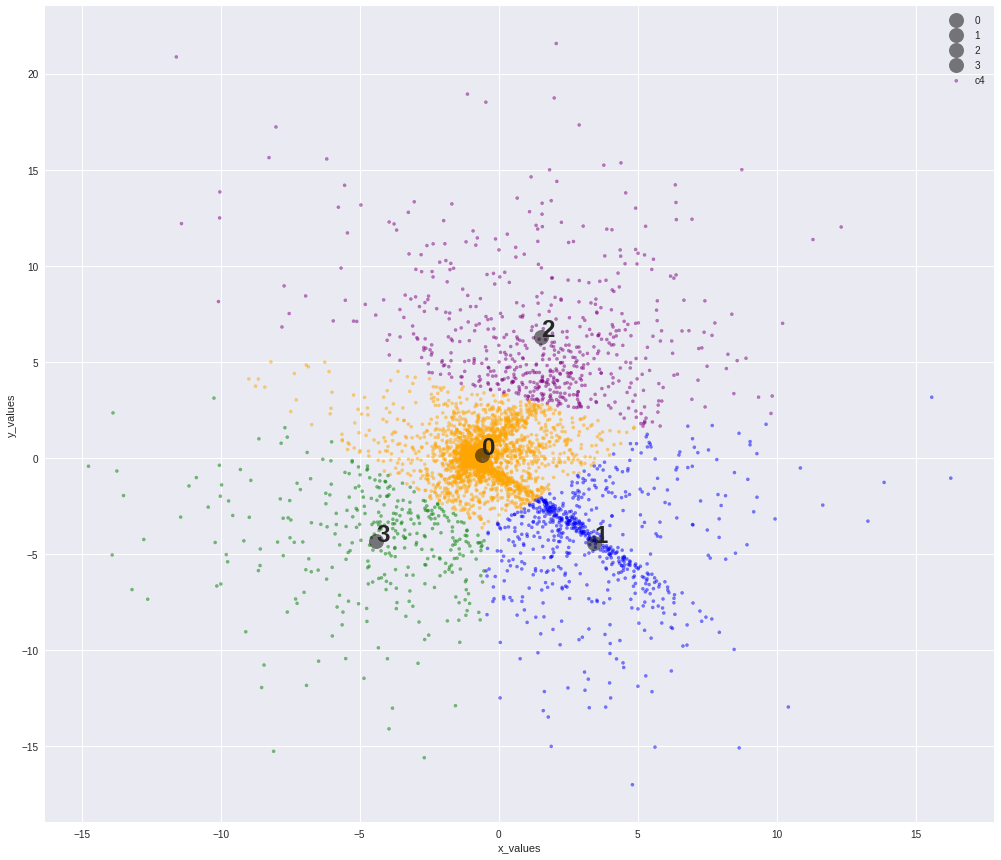

In [34]:
import matplotlib
fig = plt.figure(figsize=(17,15))
colors = ['orange','blue','purple','green','brown','red','pink','white']
colored = [colors[k] for k in c_preds]
plt.scatter(tocluster['c6'],tocluster['c4'],  color = colored,s=10,alpha=0.5)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=15, color='black', alpha=0.5, label=''+str(ci))
    plt.annotate(str(ci), (c[0],c[1]),fontsize=24,fontweight='bold')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [35]:
employee['cluster']=c_preds

here is how employees are distributed among clusters

In [36]:
tot_cluster = employee.groupby('cluster').count()['employee']
tot_churn = len(employee[employee['stillExists']==False])
tot_cluster

cluster
0    2811
1     638
2     597
3     331
Name: employee, dtype: int64

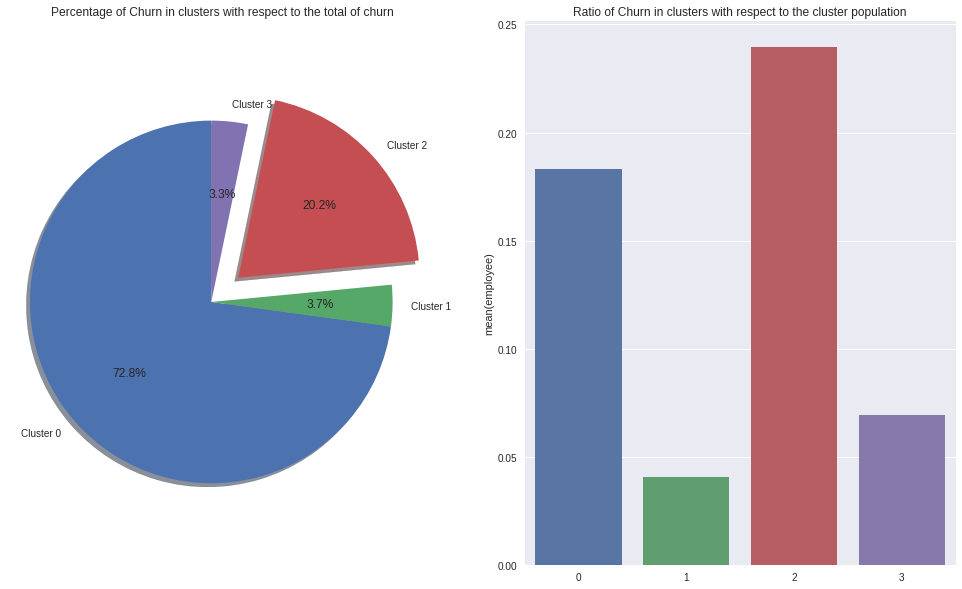

In [37]:
tmp = employee[employee['stillExists']==False].groupby('cluster',as_index='False').count()['employee']
churn_perc_totchurn = tmp/tot_churn
tmp=employee[employee['stillExists']==False].groupby('cluster',as_index='False').count()['employee']
churn_perc_totcluster = tmp/tot_cluster
fig1, axarr = plt.subplots(1,2,figsize=(17,10))
explode = (0, 0, 0.2, 0)
labels = 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'
axarr[0].pie(churn_perc_totchurn, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
axarr[0].axis('equal')  
axarr[0].set_title('Percentage of Churn in clusters with respect to the total of churn')
sns.barplot(x=[0,1,2,3],y=churn_perc_totcluster,ax=axarr[1])
axarr[1].set_title('Ratio of Churn in clusters with respect to the cluster population')
plt.show()

This is interesting and I think it will deserve a more detailed analysis: although the third cluster is particulary small (597 individuals) it contains 20% of the employees that laved the Company. We might have found something intersting.

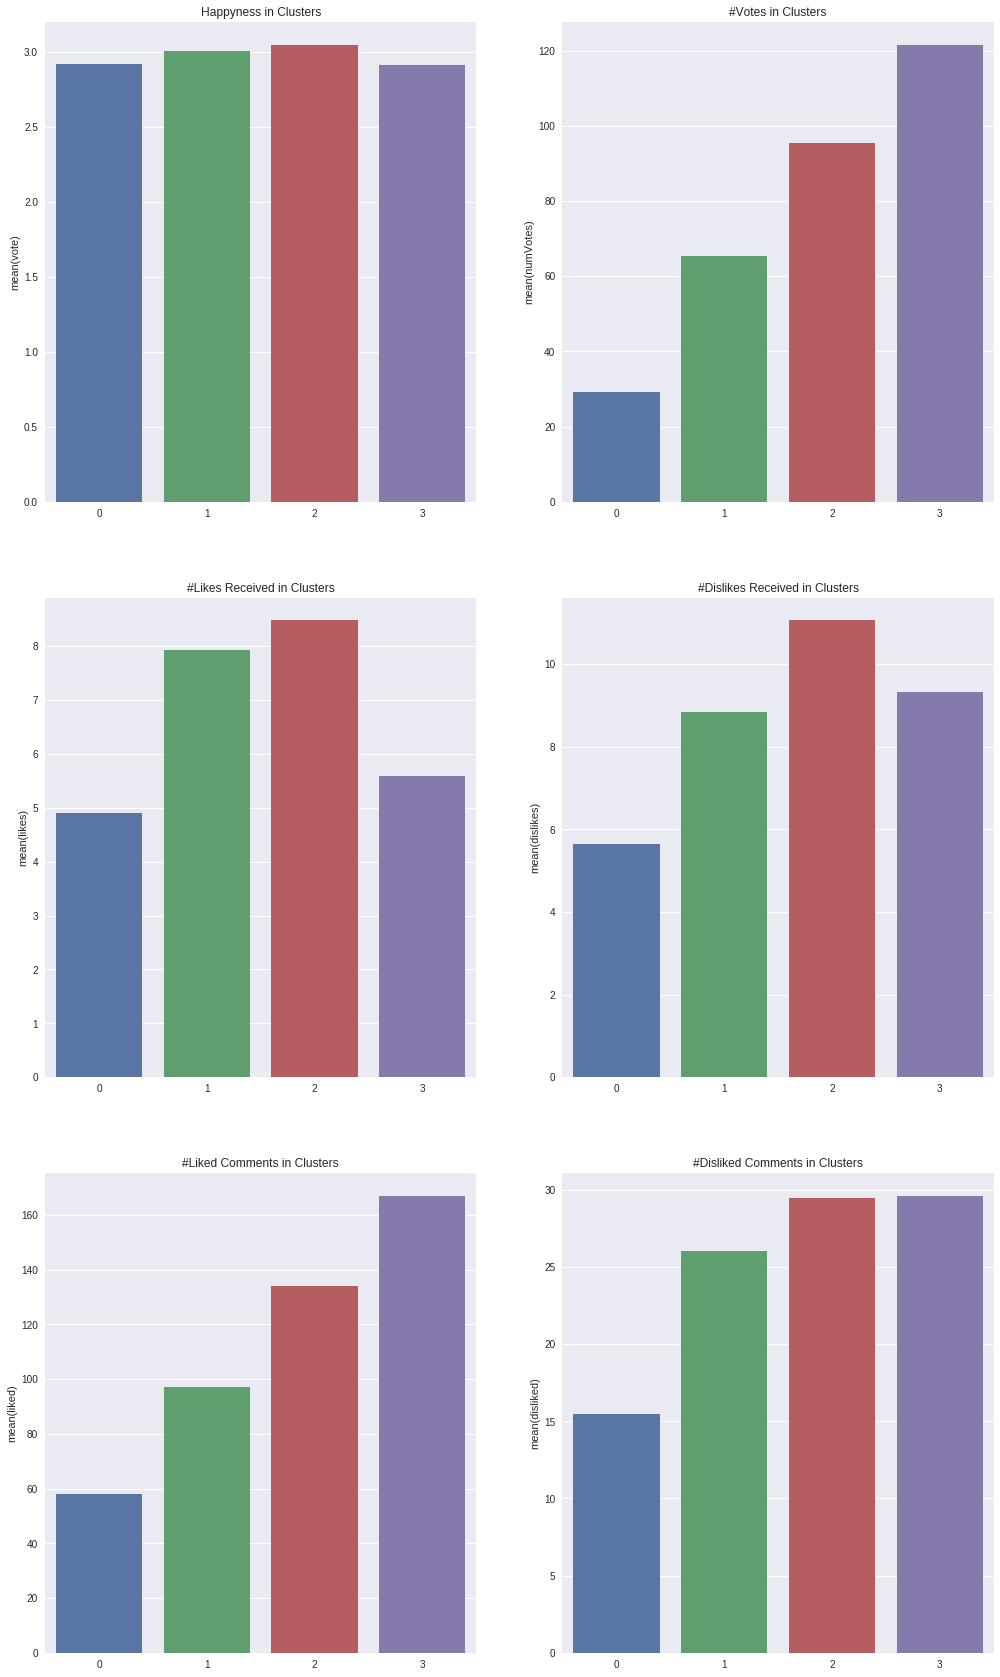

In [38]:
vote_cluster = employee.groupby('cluster',as_index='False').mean()['vote']
nvote_cluster = employee.groupby('cluster',as_index='False').mean()['numVotes']
likes_cluster = employee.groupby('cluster',as_index='False').mean()['likes']
dislikes_cluster = employee.groupby('cluster',as_index='False').mean()['dislikes']
liked_cluster = employee.groupby('cluster',as_index='False').mean()['liked']
disliked_cluster = employee.groupby('cluster',as_index='False').mean()['disliked']
fig,axarray = plt.subplots(3,2,figsize=(17,30))
sns.barplot(x=[0,1,2,3],y=vote_cluster,ax=axarray[0,1])
axarray[0,1].set_title('Happyness in Clusters')
sns.barplot(x=[0,1,2,3],y=vote_cluster,ax=axarray[0,0])
axarray[0,0].set_title('Happyness in Clusters')
sns.barplot(x=[0,1,2,3],y=nvote_cluster,ax=axarray[0,1])
axarray[0,1].set_title('#Votes in Clusters')
sns.barplot(x=[0,1,2,3],y=likes_cluster,ax=axarray[1,0])
axarray[1,0].set_title('#Likes Received in Clusters')
sns.barplot(x=[0,1,2,3],y=dislikes_cluster,ax=axarray[1,1])
axarray[1,1].set_title('#Dislikes Received in Clusters')
sns.barplot(x=[0,1,2,3],y=liked_cluster,ax=axarray[2,0])
axarray[2,0].set_title('#Liked Comments in Clusters')
sns.barplot(x=[0,1,2,3],y=disliked_cluster,ax=axarray[2,1])
axarray[2,1].set_title('#Disliked Comments in Clusters')
plt.show()

## Time Series

In [39]:
c1_sample = employee[employee['cluster']==2].head(5)

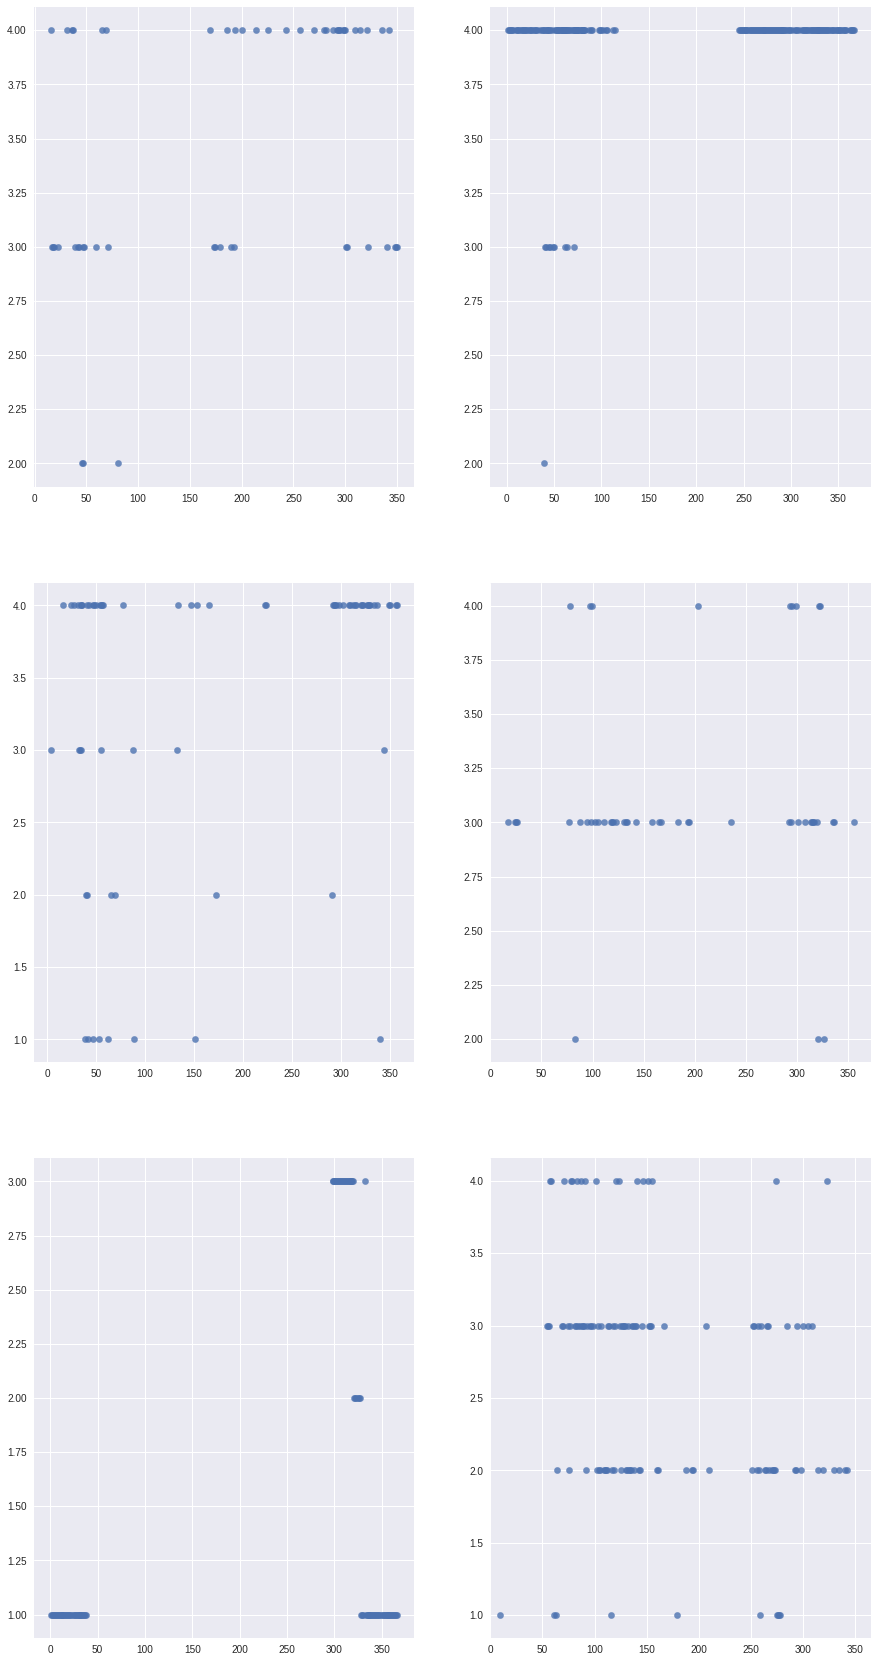

In [40]:
f,axarr = plt.subplots(3,2,figsize=(15,30))
sample = employee[employee['cluster']==2][0:6]
vtp = votes[votes['employee']==sample['employee'].iloc[0]]
axarr[0,0].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[1]]
axarr[0,1].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[2]]
axarr[1,0].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[3]]
axarr[1,1].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[4]]
axarr[2,0].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[5]]
axarr[2,1].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)

plt.xlim(0,365)
plt.show()

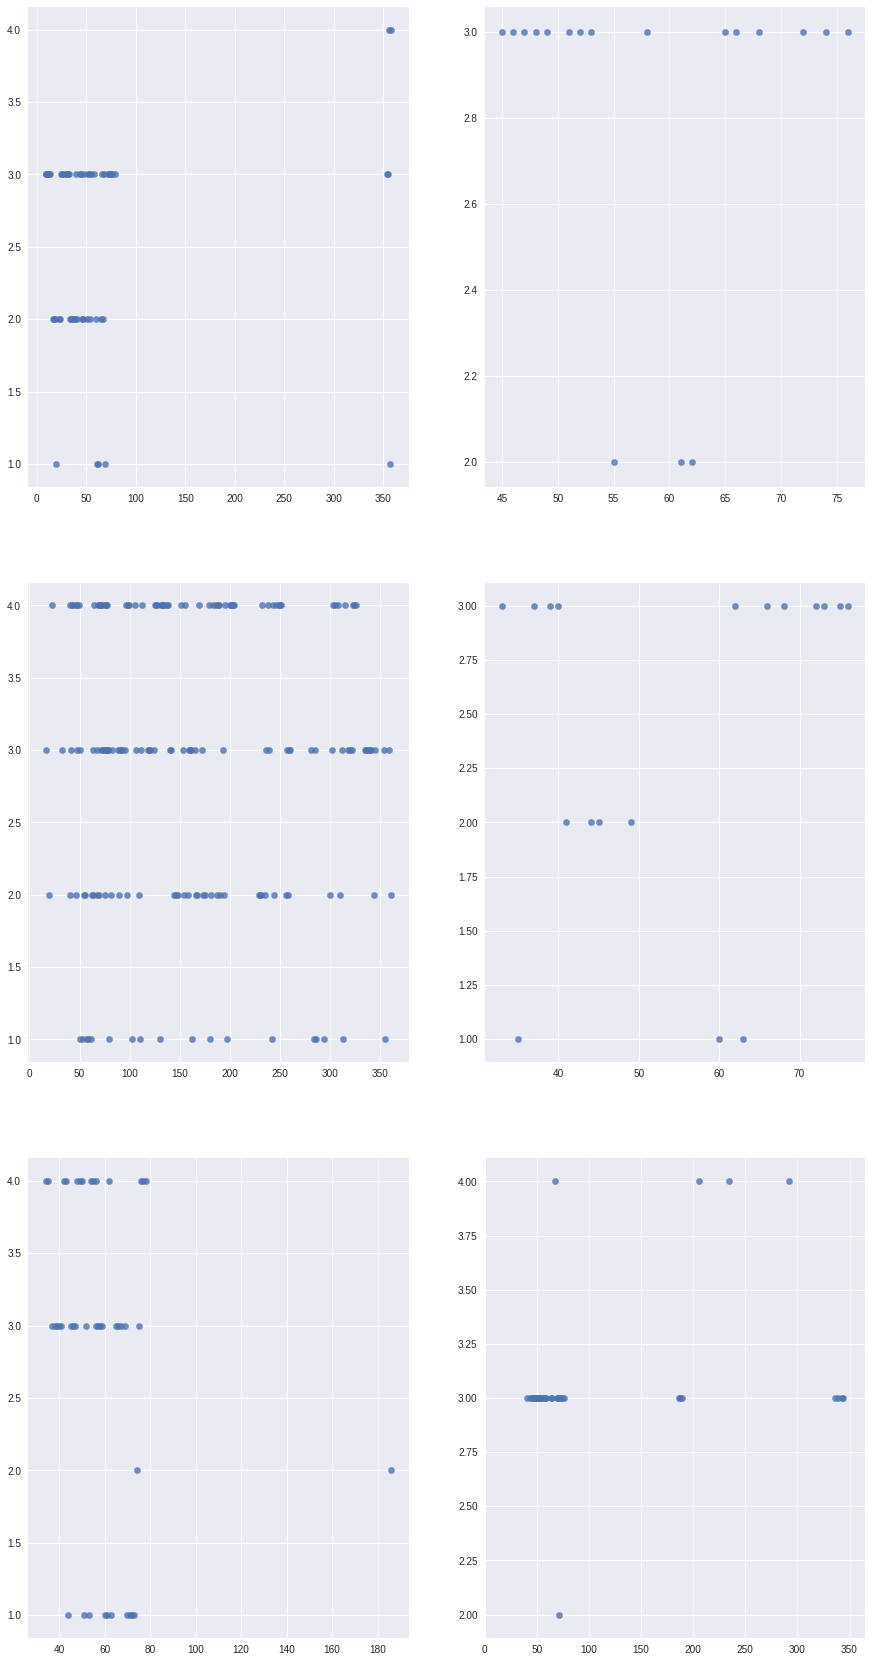

In [41]:
f,axarr = plt.subplots(3,2,figsize=(15,30))
sample = employee[employee['cluster']==1][20:26]
vtp = votes[votes['employee']==sample['employee'].iloc[0]]
axarr[0,0].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[1]]
axarr[0,1].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[2]]
axarr[1,0].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[3]]
axarr[1,1].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[4]]
axarr[2,0].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)
vtp = votes[votes['employee']==sample['employee'].iloc[5]]
axarr[2,1].scatter(x=vtp['yday'].values,y=vtp['vote'].values,s=40,alpha=0.8)

plt.xlim(0,365)
plt.show()

Work in progress - Stay Tuned